In [126]:
import numpy as np
import io3d
import pandas as pd
import skimage
import skimage.draw
import matplotlib.pyplot as plt
import skimage.io
import scipy.ndimage
import skimage.morphology
import sklearn.decomposition

In [12]:
pth = io3d.joinp("downloads/imm403/")
if not pth.exists():
    pth.mkdir(parents=True, exists_ok=True)
    io3d.datasets.downzip('http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/403/zip/imm403.zip',str(pth))

In [50]:
df = pd.read_csv(pth / 'all/shapes/shapes.txt', delimiter=' ', header=None)


In [53]:
pths = list((pth / "all/images").glob("*.jpg"))

In [73]:
def get_hand(im):
    imhsv = skimage.color.rgb2hsv(im)
    im0 = imhsv[:,:,1]>.25
    im1 = skimage.morphology.remove_small_objects(im0)
    im2 = scipy.ndimage.binary_fill_holes(im1)
    return im2

# plt.imshow(im2)

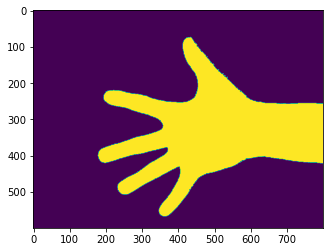

In [78]:
im = skimage.io.imread(pths[10])
imh = get_hand(im)
plt.imshow(imh)

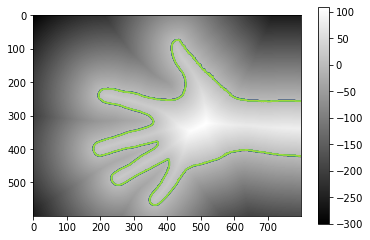

In [87]:
def get_sdf(imh):
    return scipy.ndimage.distance_transform_edt(imh) - scipy.ndimage.distance_transform_edt(~imh)
sdf = get_sdf(imh)
plt.imshow(sdf, cmap='gray')
plt.colorbar()
plt.contour(imh)

In [88]:
imh.shape

(600, 800)

In [90]:
data = np.zeros([len(pths), 600, 800])
for i, pth in enumerate(pths):
    im = skimage.io.imread(pths[i])
    imh = get_hand(im)
    sdf = get_sdf(imh)
    data[i] = sdf
    

In [98]:
features = data.reshape([data.shape[0], np.prod(data.shape[1:])])

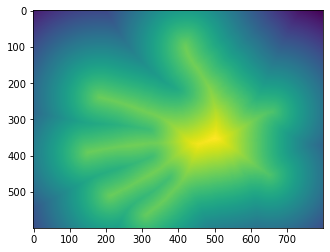

In [99]:
imre = features[0].reshape([data.shape[1], data.shape[2]])
plt.imshow(imre)

# PCA

In [102]:
# cov_matrix = np.cov(features)
# cov_matrix.shape

(40, 40)

In [177]:
# values, vectors = np.linalg.eig(cov_matrix)

In [179]:
# vectors[0]

# Mean shape

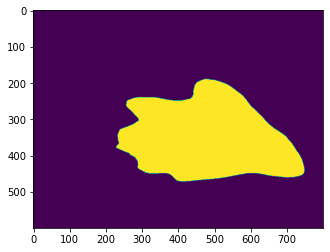

In [110]:
mnshape = np.mean(features, axis=0)
plt.imshow(mnshape.reshape(data.shape[1:]) > 0)

In [117]:
S = np.mat((features - mnshape))

In [121]:
(S * S.T).shape

(40, 40)

# SVD

In [176]:
# np.linalg.svd(S) # Out of memory

In [180]:
# Alternative SVD
svd = sklearn.decomposition.TruncatedSVD(n_components=5)
svd.fit(S)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=5,
             random_state=None, tol=0.0)

In [140]:
svd.components_.shape

(5, 480000)

In [141]:
svd.singular_values_

array([81367.50061176, 71948.07073008, 58269.14470085, 49182.7258405 ,
       37169.15943113])

In [155]:
diffs = np.matmul(np.array(weights).reshape([1,-1]), svd.components_ )

In [156]:
diffs[0,:5]

array([-4.98635519e-05, -5.37970067e-05, -5.77492431e-05, -6.17203336e-05,
       -6.57071897e-05])

In [158]:
svd.components_[0,:5]

array([-4.98635519e-05, -5.37970067e-05, -5.77492431e-05, -6.17203336e-05,
       -6.57071897e-05])

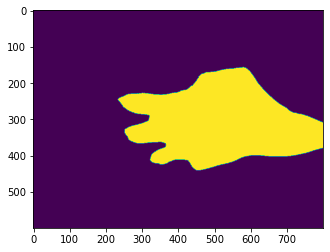

In [189]:

weights_std = [1, 2, 0, 0, 0]  # multiplication of variances of components
weights = weights_std*svd.explained_variance_**0.5
def get_shape(weights):
    dfshape = np.matmul(np.array(weights).reshape([1,-1]), svd.components_ )
    new_sdf = (mnshape + dfshape).reshape(data.shape[1:])
    return (new_sdf > 0).reshape(data.shape[1:])

im = get_shape(weights)
plt.imshow(im)

# Get new features


In [190]:
img_id = 0
w = np.matmul(svd.components_, features[img_id] - mnshape)

In [195]:
img_id = 0
w = np.matmul(svd.components_, features[0] - mnshape)
w

array([ 13860.15306442, -14985.48921603, -11290.0852806 ,  -5201.06397849,
        -1441.3619316 ])

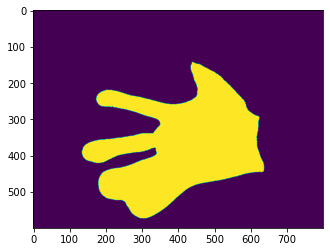

In [191]:
plt.imshow(get_shape(w))

# Shape model as a class

In [242]:
class ShapeModel():
    def __init__(self,n_components=3):
        self.n_components = n_components
        self.mshape = None
        self.svd = None
        self.input_shape = None
    
    
    def fit(self, masks:np.ndarray):
        """
        masks: shape=[number_of_images, image_shape_0, image_shape_1, ...]
        """
        features = self._transform_and_make_sdf(masks)
        self.mnshape = np.mean(features, axis=0)
        
        # get the diffs from mean shape
        S = np.mat((features - mnshape))
        self.svd = sklearn.decomposition.TruncatedSVD(n_components=self.n_components)
        self.svd.fit(S)
        self.input_shape = masks.shape
        self.input_ndim = masks.ndim
        
    def _transform_and_make_sdf(self, masks):
        sdfs = np.empty(masks.shape, dtype=float)
        for i in range(masks.shape[0]):
            sdf = scipy.ndimage.distance_transform_edt(masks[i]>0) - scipy.ndimage.distance_transform_edt(~(masks[i]>0))
            sdfs[i]=sdf
        
        features = sdfs.reshape([sdfs.shape[0], np.prod(sdfs.shape[1:])])
        return features
        
    def transform(self, masks:np.ndarray):
        """
        Get transformed features for unknow mask
        """
        features = self._transform_and_make_sdf(masks)
        ws = []
        for img_id in range(masks.shape[0]):
            w = np.matmul(self.svd.components_, features[img_id] - self.mnshape)
            ws.append(w)
        return np.asarray(ws)
    
    def inverse_transform(self, weights):
        
        masks = []
        for i in range(weights.shape[0]):
            dfshape = np.matmul(np.array(weights[i]).reshape([1,-1]), self.svd.components_ )
            new_sdf = (self.mnshape + dfshape).reshape(self.input_shape[1:])
            masks.append((new_sdf > 0).reshape(self.input_shape[1:]))
        
        return np.asarray(masks)

## Example: 5 components

In [272]:

n_components = 5

In [261]:
masks = np.asarray([get_hand(skimage.io.imread(pth)) for pth in pths])

In [273]:
shm = ShapeModel(n_components=n_components)
shm.fit(masks)

In [274]:
# Get features of first two shapes
test_masks = masks[4:7]
fts = shm.transform(test_masks)
fts

array([[  9936.90224212, -17273.16631213,  -2334.27551235,
          6294.41292899,  -2281.16589094],
       [  5212.05356929, -16402.54952238,   2348.34838469,
         17478.02035677,   4124.04316436],
       [ 29661.7390039 ,  38401.21817617, -11085.01843714,
         13920.85796756,   9682.07237315]])

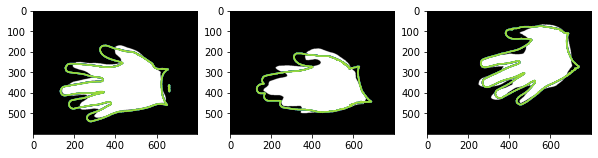

In [275]:
# Reconstruct the shapes
shps = shm.inverse_transform(fts)
fig, axs = plt.subplots(1,shps.shape[0], figsize=(10,10))
for i in range(len(axs)):
    axs[i].imshow(shps[i]>0, cmap='gray')
    axs[i].contour(test_masks[i])

# Example: 30 components

In [276]:
n_components = 20
shm = ShapeModel(n_components=n_components)
shm.fit(masks)
# Get features of first two shapes
test_masks = masks[4:7]
fts = shm.transform(test_masks)
fts

array([[  9936.90224212, -17273.16631213,  -2334.27551246,
          6294.41292847,  -2281.16588581,   3442.51779158,
           535.06119454,   3024.9159559 ,   -109.60510519,
          1174.38621652,  -1634.45533231,   -616.18386744,
         -1969.0123249 ,   2210.5396869 ,    -61.54201648,
          -454.14264968,    497.98745595,     50.43092168,
         -1707.44415332,   -886.08323509],
       [  5212.05356929, -16402.54952237,   2348.34838465,
         17478.02035652,   4124.04318141,   5685.13978361,
         -3069.50877445,   1494.15215848,   4152.03446763,
          2597.56343364,   3815.78219754,  -2144.74967595,
          2112.96253164,   -778.04415972,    268.78741295,
          1322.11079102,   1153.18869289,   -168.17096296,
           657.71713768,    920.84696234],
       [ 29661.7390039 ,  38401.21817617, -11085.01843705,
         13920.85796821,   9682.07234725,  -2677.13332993,
           941.60580709,  -1897.71200598,   2405.44155327,
         -2137.39298301,  -26

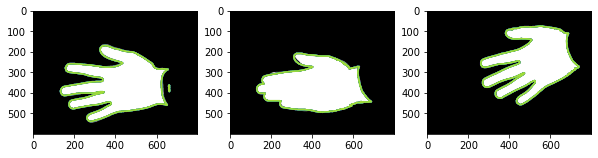

In [277]:
# Reconstruct the shapes
shps = shm.inverse_transform(fts)
fig, axs = plt.subplots(1,shps.shape[0], figsize=(10,10))
for i in range(len(axs)):
    axs[i].imshow(shps[i]>0, cmap='gray')
    axs[i].contour(test_masks[i])

## Example - smoothing

In [280]:
test_masks[:, 400:420, 80:400] = 1

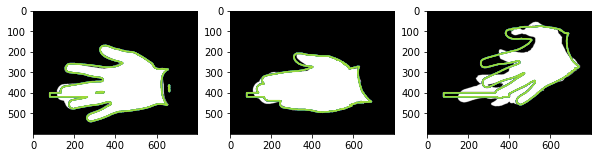

In [281]:
fts = shm.transform(test_masks)
fts
# Reconstruct the shapes
shps = shm.inverse_transform(fts)
fig, axs = plt.subplots(1,shps.shape[0], figsize=(10,10))
for i in range(len(axs)):
    axs[i].imshow(shps[i]>0, cmap='gray')
    axs[i].contour(test_masks[i])

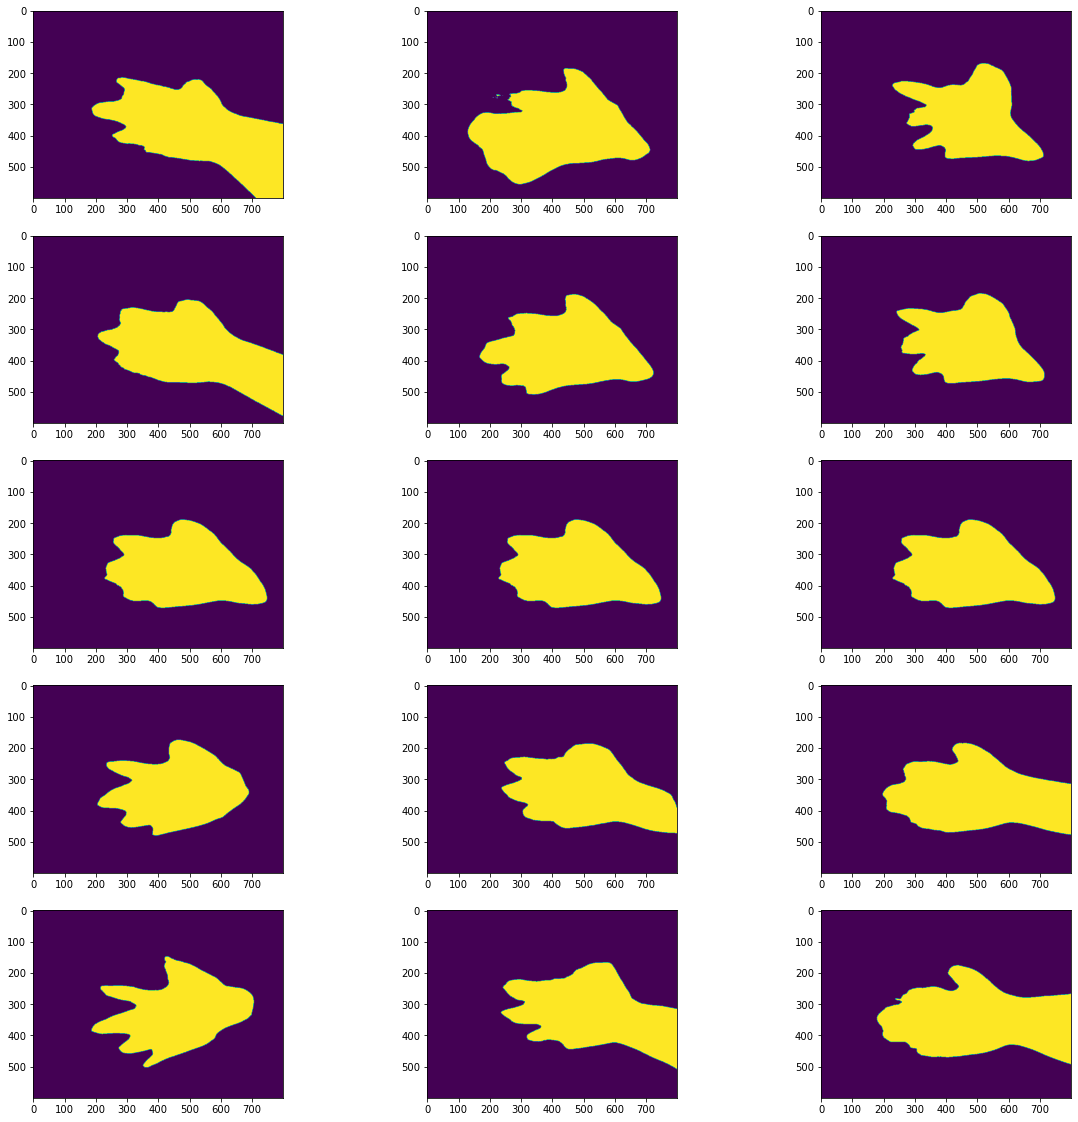

In [291]:
## Show components
import itertools
first_n_components = 3

fig, axs = plt.subplots(5, first_n_components, figsize=(20,20))
for i,j in itertools.product(range(first_n_components), range(0,5)):
    w = np.zeros([1, n_components])
    w[0, i] = j - 2
    shps = shm.inverse_transform(w * shm.svd.explained_variance_**0.5)
    axs[j,i].imshow(shps[0] > 0)

In [ ]:
axs